In [9]:
from pystats_utils.utils.patient import Patient

import pandas as pd

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Mortality_31d"] == "no"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))
    
keys = ["Days", "Changes", "Atbs"]
times = ["Total", "Pre", "Post"]
groups = {"Amikacin"    : "Aminoglicosidos",
          "Gentamicin"  : "Aminoglicosidos",
          "Tigecycline" : "Tigecycline",
          "Colistin"    : "Polimixinas",
          "Polymyxin"   : "Polimixinas",
          "Caz-avi"     : "Caz-avi"}

result = {key : {time : {group : [] for group in groups.values()} for time in times} for key in keys}

for patient in patients:
    
    allAtbs = [element for step in patient.translateTreatmentLine(only = "active",
                                                                condensed = True,
                                                                days = False) for element in step if element != "None"]
    
    for atb in groups:
        if atb in allAtbs:
            
            # Days
            dayTreatment = patient.translateTreatmentLine(only = "active",
                                                          days = False)
            for index, day in enumerate(dayTreatment):
                
                if atb in day:
                    result["Days"]["Total"][groups[atb]].append(len(dayTreatment))
                    result["Days"]["Pre"][groups[atb]].append(index)
                    result["Days"]["Post"][groups[atb]].append(len(dayTreatment) - index - 1)
                    break
                    
            # Changes
            changeTreatment = patient.translateTreatmentLine(mergeInactive = True,
                                                             condensed = True,
                                                             days = False)
            for index, step in enumerate(changeTreatment):
                
                if atb in step:
                    result["Changes"]["Total"][groups[atb]].append(len(changeTreatment))
                    result["Changes"]["Pre"][groups[atb]].append(index)
                    result["Changes"]["Post"][groups[atb]].append(len(changeTreatment) - index - 1)
                    break
                    
            # Changes
            atbsTreatment = patient.translateTreatmentLine(condensed = True,
                                                           mergeInactive = False,
                                                           days = False)
            for index, step in enumerate(atbsTreatment):
                if f"{atb}_S" in step:
                                        
                    allAtbs = set([element for step in atbsTreatment for element in step if element != "None"])
                    
                    result["Atbs"]["Total"][groups[atb]].append(len(allAtbs) - 1)
                    
                    preAtbs = set([element for step in atbsTreatment[:index] for element in step if element != "None"])
                    if f"{atb}_s" in preAtbs: preAtbs.remove(f"{atb}_s")
                    
                    result["Atbs"]["Pre"][groups[atb]].append(len(preAtbs))
                    
                    posAtbs = set([element for step in atbsTreatment[index + 1:] for element in step if element != "None"])
                    if f"{atb}_s" in posAtbs: posAtbs.remove(f"{atb}_s")
                    
                    result["Atbs"]["Post"][groups[atb]].append(len(posAtbs))
                    break

In [10]:
import pandas as pd

template = {}

flag = True

for key, value in result.items():
    for time, value in value.items():
        aux = []
        
        names = []
        
        for group, values in value.items():
            aux += values
            names += [group] * len(values)
            
        if flag:
            template["group"] = names
            
        template[f"{key}_{time}"] = aux
        
data = pd.DataFrame(template)
data

,group,Days_Total,Days_Pre,Days_Post,Changes_Total,Changes_Pre,Changes_Post,Atbs_Total,Atbs_Pre,Atbs_Post
0,Aminoglicosidos,3,0,2,4,0,3,3,0,3
1,Aminoglicosidos,2,0,1,4,0,3,3,0,4
2,Aminoglicosidos,1,0,0,2,0,1,2,0,3
3,Aminoglicosidos,5,1,3,6,1,4,4,1,4
4,Aminoglicosidos,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
110,Caz-avi,1,0,0,1,0,0,0,0,0
111,Caz-avi,2,0,1,2,0,1,1,0,1
112,Caz-avi,2,0,1,2,0,1,1,0,1
113,Caz-avi,1,0,0,1,0,0,1,0,0


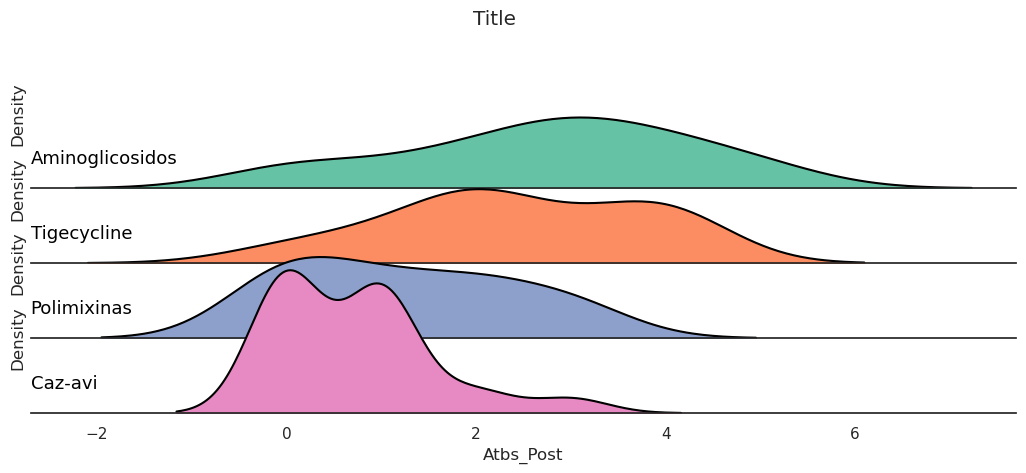

In [18]:
from pystats_utils.plot import RidgePlot

plot = RidgePlot(dataframe = data,
                 classVariable = "group",
                 targetVariable = "Atbs_Post").run()

plot